<a href="https://colab.research.google.com/github/ndow33/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# TODO - your code!

#1.Generate and numerically represent a confidence interval

In [0]:
#Import libraries and load the data 
import numpy as np
import pandas as pd
from scipy.stats import t, ttest_1samp, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
#get the raw data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-02-05 03:11:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-02-05 03:11:34 (277 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [0]:
# make into a dataframe
column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

In [0]:
df = pd.read_csv('house-votes-84.data', header = None,
                 names=column_headers,
                 na_values='?')

In [6]:
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [7]:
# recode votes as numeric
df = df.replace({'y':1, 'n':0})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [8]:
# how many from each party?
df['party'].value_counts().sort_index()


democrat      267
republican    168
Name: party, dtype: int64

In [9]:
# how did Republicans vote?
rep = df[df['party']=='republican']
rep.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [10]:
# how did Democrats vote?
dem = df[df['party']=='democrat']
dem.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [11]:
# the percentage of republicans who voted "yes" (1) 
# on the handicapped-infants bill
rep['handicapped-infants'].sum()/len(rep)

# len() is counting NaN values too!

0.18452380952380953

In [12]:
# Remove NaN values from this column
col = rep['handicapped-infants']
np.isnan(col)
hi_no_nans = col[~np.isnan(col)]
# The same column as before, but I've dropped the NaN values
hi_no_nans

0      0.0
1      0.0
7      0.0
8      0.0
10     0.0
      ... 
427    0.0
430    0.0
432    0.0
433    0.0
434    0.0
Name: handicapped-infants, Length: 165, dtype: float64

In [13]:
# Average rate of voting 'yes' on the handicapped-infants
#.mean() filters through nan's automatically
rep_mean = rep['handicapped-infants'].mean()
rep_mean

0.18787878787878787

In [0]:
#use t.interval for the confidence interval
#use this cell for all of the variables needed for t.interval

#sample size of voting republicans
n = 168
#degrees of freedom
dof = n-1
#the mean of the means is actually just the mean of the republicans suupport of this bill
big_mean = rep_mean
#sample standard deviation
sample_std = np.std(rep['handicapped-infants'], ddof=1)
#standard error
std_err = sample_std/n**.5

In [15]:
#confidence interval
CI = t.interval(.95, dof, loc=big_mean, scale=std_err)
CI

(0.12819979769991746, 0.24755777805765827)

#2. Graphically (with a plot) represent the confidence interval

Lower limit of the CI: 12.8% 
Upper limit of the CI: 24.8% 
Observed mean of republican support: 18.8%


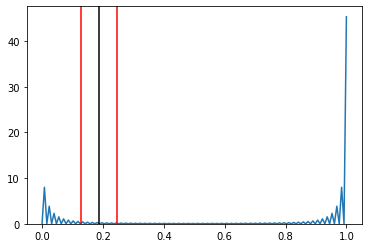

In [16]:
# use the mean of the republican votes to generate 100 sample means 
vote_flips = np.random.binomial(n=1, p=rep_mean, size=168)
# kernel density estimate
sns.kdeplot(vote_flips)
#confidence interval
plt.axvline(x=0.12819979769991746, color='red')
plt.axvline(x=0.24755777805765827, color='r')
plt.axvline(x=rep_mean, color='k');

print('Lower limit of the CI: 12.8%', 
      '\nUpper limit of the CI: 24.8%',
      '\nObserved mean of republican support: 18.8%')

Lower limit of the CI:  0.12819979769991746 
Upper limit of the CI:  0.24755777805765827 
Observed mean of republican support:  0.18787878787878787


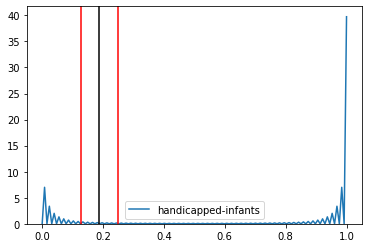

In [17]:
# use the mean of the republican votes to generate 100 sample means 
#vote_flips = np.random.binomial(n=1, p=rep_mean, size=168)
# kernel density estimate
sns.kdeplot(rep['handicapped-infants'])
#confidence interval
plt.axvline(CI[0], color='red')
plt.axvline(CI[1], color='r')
plt.axvline(x=rep_mean, color='k');

print('Lower limit of the CI: ', CI[0], 
      '\nUpper limit of the CI: ', CI[1],
      '\nObserved mean of republican support: ', rep_mean)

##I'm not sure why my graph turned out this way...Any suggestions?

#3. Interpret the confidence interval - what does it tell you about the data and its distribution?

This confidence interval tells us with 95% certainty that the true proportion of the republican population that supports this handicapped infants bill lies between 12.8% and 24.8% 

In other words, we can be 95% confident that between 12.8% and 24.8% of the republican population support this handicapped infants bill. 

#4. Take a dataset that we have used in the past in class that has categorical variables. Pick two of those categorical variables and run a chi-squared tests on that data

By hand using Numpy

In [0]:
url='https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv'

In [19]:
#Remove null values
adult_df = pd.read_csv(url, na_values=' ?')
adult_df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
17974,46,Private,102569,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,65,United-States,>50K
28065,26,Private,171114,Bachelors,13,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K
14329,64,Private,46087,Bachelors,13,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,50,United-States,<=50K
24481,42,Self-emp-not-inc,185129,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1887,40,United-States,>50K
21902,38,Private,187870,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,7298,0,50,United-States,>50K
25862,48,Self-emp-not-inc,353012,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1902,40,United-States,>50K
24764,33,Private,279173,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,<=50K
30093,60,Private,250552,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,>50K
12000,37,Self-emp-not-inc,75050,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,55,United-States,<=50K
10440,19,NaN,252292,HS-grad,9,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K


In [20]:
adult_df.dropna(how='any')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [21]:
adult_df['race'].value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

In [22]:
adult_df['education'].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

In [23]:
x_table = pd.crosstab(adult_df['race'], adult_df['education'], margins=True)
x_table

education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,All
race,,,,,,,,,,,,,,,,,
Amer-Indian-Eskimo,16,14,5,4,2,9,5,8,19,21,3,119,5,0,2,79,311
Asian-Pac-Islander,13,21,9,5,18,11,9,29,38,289,28,226,88,6,41,208,1039
Black,133,153,70,16,21,56,89,107,112,330,11,1174,86,5,15,746,3124
Other,9,10,14,9,13,17,8,8,6,33,2,78,7,2,4,51,271
White,762,977,335,134,279,553,403,915,1207,4682,369,8904,1537,38,514,6207,27816
All,933,1175,433,168,333,646,514,1067,1382,5355,413,10501,1723,51,576,7291,32561


In [24]:
#create a set of Amer-Indian-Eskimo counts
amer_count = x_table.iloc[0][0:16].values
amer_count

array([ 16,  14,   5,   4,   2,   9,   5,   8,  19,  21,   3, 119,   5,
         0,   2,  79])

In [25]:
#create a set of Asian-Pac-Islander counts
asia_count = x_table.iloc[1][0:16].values
asia_count

array([ 13,  21,   9,   5,  18,  11,   9,  29,  38, 289,  28, 226,  88,
         6,  41, 208])

In [26]:
#create a set of Black counts
black_count = x_table.iloc[2][0:16].values
black_count

array([ 133,  153,   70,   16,   21,   56,   89,  107,  112,  330,   11,
       1174,   86,    5,   15,  746])

In [27]:
#create a set of other counts
other_count = x_table.iloc[3][0:16].values
other_count

array([ 9, 10, 14,  9, 13, 17,  8,  8,  6, 33,  2, 78,  7,  2,  4, 51])

In [28]:
#create a set of white counts
white_count = x_table.iloc[4][0:16].values
white_count

array([ 762,  977,  335,  134,  279,  553,  403,  915, 1207, 4682,  369,
       8904, 1537,   38,  514, 6207])

In [0]:
#category labels
label_names = ['10th', '11th', '12th', '1st-4th',	'5th-6th',	'7th-8th',	'9th',
               'Assoc-acdm',	'Assoc-voc',	'Bachelors',	'Doctorate',	'HS-grad',
               'Masters',	'Preschool',	'Prof-school',	'Some-college' ]

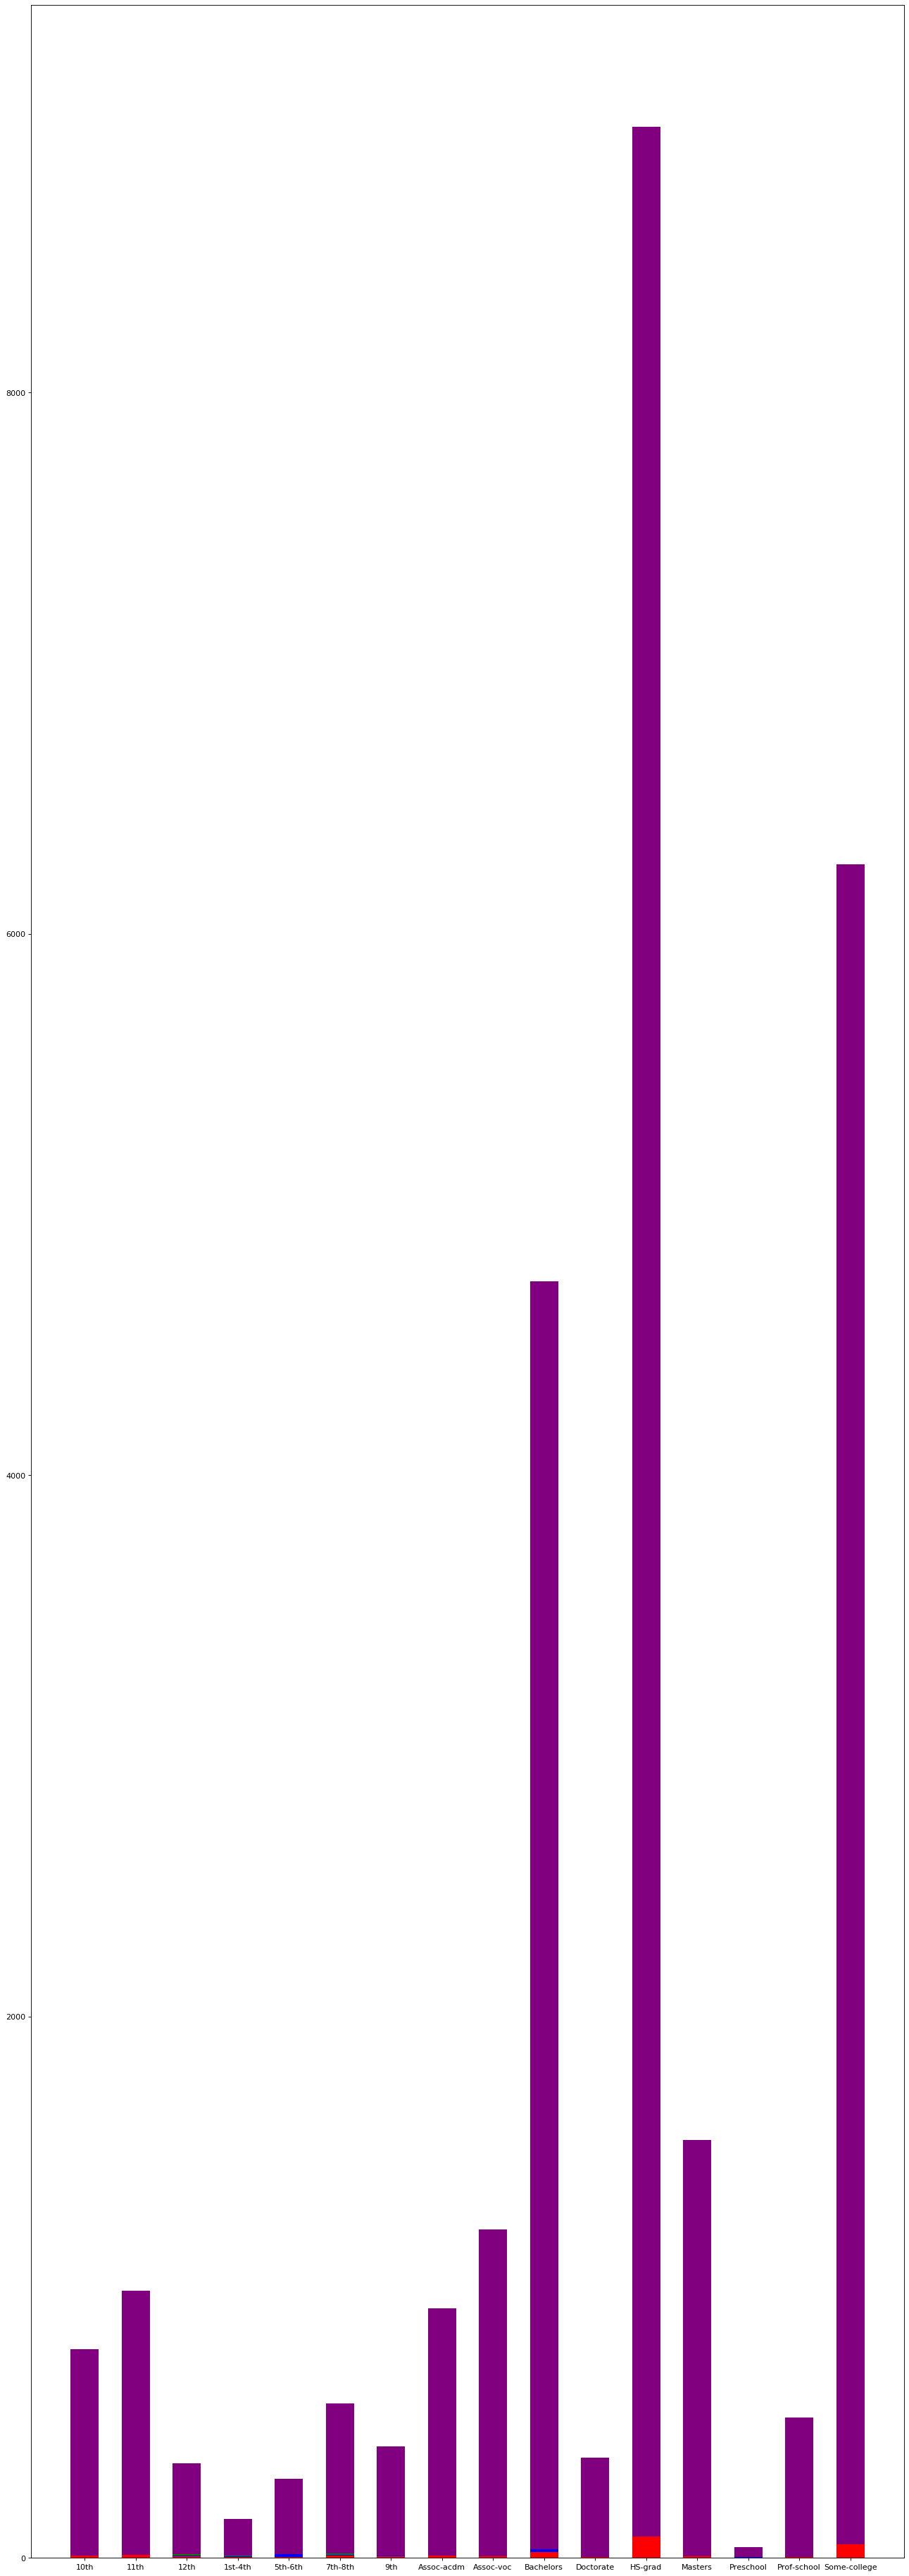

In [30]:
#plot the bar chart
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 60), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.bar(label_names, amer_count, 0.55, color='red')
p2 = plt.bar(label_names, asia_count, 0.55, color='blue', bottom=amer_count)
p3 = plt.bar(label_names, black_count, 0.55, color='green', bottom=asia_count)
p4 = plt.bar(label_names, other_count, 0.55, color='orange', bottom=black_count)
p5 = plt.bar(label_names, white_count, 0.55, color='purple', bottom=other_count)

In [31]:
#expected value calculations
#start by finding the sum of the columns and rows

row_sums = x_table.iloc[0:5, 16].values
col_sums = x_table.iloc[5, 0:16].values
print(row_sums)
col_sums

[  311  1039  3124   271 27816]


array([  933,  1175,   433,   168,   333,   646,   514,  1067,  1382,
        5355,   413, 10501,  1723,    51,   576,  7291])

In [32]:
#find the total number of people in our adult dataframe
total = x_table.loc['All', 'All']
total

32561

In [0]:
#use a nested for loop to find the expected values for the different
#race/education combinations

expected = []
for i in range(len(row_sums)):
  expected_row=[]
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)

In [34]:
#show what the expected distribution would look like
for i in range(5):
  print(expected[i])


[  8.91136636  11.22278186   4.13571451   1.60461902   3.18058413
   6.17014219   4.90937011  10.19124106  13.19990172  51.14723135
   3.94468843 100.29824023  16.45689629   0.48711649   5.50155094
  69.63855533]
[ 29.77141365  37.49347379  13.81674396   5.36076902  10.62581002
  20.61343325  16.40140045  34.04726513  44.09870704 170.87451245
  13.17855717 335.07997297  54.97979178   1.62737631  18.37977949
 232.65099352]
[  89.51481834  112.73302417   41.54331869   16.11842388   31.94901876
   61.97917754   49.31470164  102.37118025  132.59322502  513.77476122
   39.62445871 1007.49743558  165.30978778    4.89309296   55.26316759
  699.52040785]
[ 7.76520991  9.77933724  3.60378981  1.39823715  2.77150579  5.37655477
  4.27793987  8.8804705  11.50216517 44.56880931  3.43733301 87.39814502
 14.34025368  0.42446485  4.79395596 60.68182795]
[ 797.03719173 1003.77138294  369.90043303  143.51795092  284.47308129
  551.86069224  439.09658794  911.50984306 1180.60600104 4574.63468567
  352.8

In [35]:
x_table

education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,All
race,,,,,,,,,,,,,,,,,
Amer-Indian-Eskimo,16,14,5,4,2,9,5,8,19,21,3,119,5,0,2,79,311
Asian-Pac-Islander,13,21,9,5,18,11,9,29,38,289,28,226,88,6,41,208,1039
Black,133,153,70,16,21,56,89,107,112,330,11,1174,86,5,15,746,3124
Other,9,10,14,9,13,17,8,8,6,33,2,78,7,2,4,51,271
White,762,977,335,134,279,553,403,915,1207,4682,369,8904,1537,38,514,6207,27816
All,933,1175,433,168,333,646,514,1067,1382,5355,413,10501,1723,51,576,7291,32561


In [36]:
#Now that we've visualized it, let's find the statistic using numpy
#Observed with no for loops
observed = pd.crosstab(adult_df['race'], adult_df['education']).values
observed

array([[  16,   14,    5,    4,    2,    9,    5,    8,   19,   21,    3,
         119,    5,    0,    2,   79],
       [  13,   21,    9,    5,   18,   11,    9,   29,   38,  289,   28,
         226,   88,    6,   41,  208],
       [ 133,  153,   70,   16,   21,   56,   89,  107,  112,  330,   11,
        1174,   86,    5,   15,  746],
       [   9,   10,   14,    9,   13,   17,    8,    8,    6,   33,    2,
          78,    7,    2,    4,   51],
       [ 762,  977,  335,  134,  279,  553,  403,  915, 1207, 4682,  369,
        8904, 1537,   38,  514, 6207]])

In [37]:
#use the numpy arrays broadcasting to calculate the chisquare stat using our observed
#values from our crosstab and the expected values from our expected values nested
#for-loop

chi_squared_stat = ((observed - expected)**2/(expected)).sum()
chi_squared_stat

730.6712962254585

In a single line using Scipy

In [38]:
#returns chi stat, p value, dof, and the expected results

import scipy.stats as stats

stats.chi2_contingency(observed)

(730.6712962254585,
 5.547319569858429e-116,
 60,
 array([[8.91136636e+00, 1.12227819e+01, 4.13571451e+00, 1.60461902e+00,
         3.18058413e+00, 6.17014219e+00, 4.90937011e+00, 1.01912411e+01,
         1.31999017e+01, 5.11472314e+01, 3.94468843e+00, 1.00298240e+02,
         1.64568963e+01, 4.87116489e-01, 5.50155094e+00, 6.96385553e+01],
        [2.97714137e+01, 3.74934738e+01, 1.38167440e+01, 5.36076902e+00,
         1.06258100e+01, 2.06134332e+01, 1.64014004e+01, 3.40472651e+01,
         4.40987070e+01, 1.70874512e+02, 1.31785572e+01, 3.35079973e+02,
         5.49797918e+01, 1.62737631e+00, 1.83797795e+01, 2.32650994e+02],
        [8.95148183e+01, 1.12733024e+02, 4.15433187e+01, 1.61184239e+01,
         3.19490188e+01, 6.19791775e+01, 4.93147016e+01, 1.02371180e+02,
         1.32593225e+02, 5.13774761e+02, 3.96244587e+01, 1.00749744e+03,
         1.65309788e+02, 4.89309296e+00, 5.52631676e+01, 6.99520408e+02],
        [7.76520991e+00, 9.77933724e+00, 3.60378981e+00, 1.39823715e+00

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)